# Problem 1 (Queueing Models)

For this problem, we are using a dataset containing scheduled and actual arrival times for Seattle's [Rapid Ride](https://kingcounty.gov/depts/transportation/metro/travel-options/bus/rapidride.aspx) line E (southbound) at the 3rd & Pike bus stop in downtown Seattle, recorded during the second quarter of 2016. You can find the dataset in the same folder as this notebook with the filename arrival_times.csv. Assume that it is stated by the state law that a Line E bus has to wait for 10 minutes at the the 3rd & Pike bus stop in downtown Seattle.
<img src="seattle-transit-map.png">

We first need to do some data preprocessing to make the dataset suitable for our analysis.

In [67]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as st
from scipy.stats import expon
import math

In [9]:
# load the dataset using panda
df = pd.read_csv('arrival_times.csv')
df = df.dropna(axis=0, how='any')
# df.head()

In [10]:
# this function converts timesteps in format H:M:S to seconds only
def get_sec(df):
    time_list = []
    for time in df:
        h, m, s = time.split(':')
        time_list.append(int(h) * 3600 + int(m) * 60 + int(s))
    return pd.Series(time_list)

In [11]:
# make the datset more readable
df['scheduled'] = df['SCH_STOP_TM']
df['actual'] = df['ACT_STOP_TM']

# add new columns with times in seconds as given by "get_sec" method
df['scheduled_in_seconds'] = get_sec(df['scheduled'])
df['actual_in_seconds'] = get_sec(df['actual'])

# sort the data based on scheduled time
df.sort_values(by=['scheduled_in_seconds'], inplace=True)
df.drop(df.tail(1).index,inplace=True)

# create two columns with shifted scheduled_in_seconds and actual_in_seconds for the 
# purpose of calculating the scheduled and actual inter arrival times 
df['next_scheduled_in_seconds'] = df['scheduled_in_seconds'].shift(periods=-1)
df['next_actual_in_seconds'] = df['actual_in_seconds'].shift(periods=-1)

# calculate scheduled and actual inter arrival times
df['scheduled_inter_arrival_times'] = df['next_scheduled_in_seconds'].subtract(df['scheduled_in_seconds'])
df['actual_inter_arrival_times'] = df['next_actual_in_seconds'].subtract(df['actual_in_seconds'])
df.drop(df.tail(1).index,inplace=True)

# extract the useful columns
df = df[['scheduled', 'actual', 'scheduled_in_seconds', 
         'actual_in_seconds','next_scheduled_in_seconds',
         'next_actual_in_seconds', 'scheduled_inter_arrival_times', 
         'actual_inter_arrival_times',]].copy()
df

,scheduled,actual,scheduled_in_seconds,actual_in_seconds,next_scheduled_in_seconds,next_actual_in_seconds,scheduled_inter_arrival_times,actual_inter_arrival_times
29,00:29:58,00:35:57,1798,2157,4078.0,4402.0,2280.0,2245.0
59,01:07:58,01:13:22,4078,4402,7798.0,8221.0,3720.0,3819.0
71,02:09:58,02:17:01,7798,8221,12298.0,12914.0,4500.0,4693.0
60,03:24:58,03:35:14,12298,12914,16078.0,16342.0,3780.0,3428.0
72,04:27:58,04:32:22,16078,16342,19798.0,19538.0,3720.0,3196.0
...,...,...,...,...,...,...,...,...
13,22:29:57,22:32:04,80997,81124,81898.0,82397.0,901.0,1273.0
28,22:44:58,22:53:17,81898,82397,82798.0,82904.0,900.0,507.0
58,22:59:58,23:01:44,82798,82904,83698.0,84159.0,900.0,1255.0
81,23:14:58,23:22:39,83698,84159,84598.0,84800.0,900.0,641.0


At this point we have a dataset suitable for our analysis. Here is a sneakpeak of the data columns. 

- scheduled : the scheduled arrival time to the bus stop
- actual : the actual arrival time to the bus stop
- scheduled_in_seconds : the scheduled arrival time to the bus stop in seconds. 0 means 0:0:0 hours of the selected day and 86400 means the 24:00:00 hours.
- actual_in_seconds : the actual arrival time to the bus stop in seconds. 0 means 0:0:0 hours of the selected day and 86400 means the 24:00:00 hours.
- next_scheduled_in_seconds : the next scheduled bus arrival time to the bus stop in seconds (given by the next row scheduled_in_seconds column). 0 means 0:0:0 hours of the selected day and 86400 means the 24:00:00 hours.
- next_actual_in_seconds : the next actual bus arrival time to the bus stop in seconds (given by the next row actual_in_seconds column). 0 means 0:0:0 hours of the selected day and 86400 means the 24:00:00 hours.
- scheduled_inter_arrival_times : scheduled inter arrival time of the two successive bus arrivals. Computed as next_scheduled_in_seconds - scheduled_in_seconds
- actual_inter_arrival_times : actual inter arrival time of the two successive bus arrivals. Computed as next_actual_in_seconds - actual_in_seconds


## Question 1 

Plot the histograms of scheduled and actual inter-arrival times each with 20 bins.  State whether the two data sets seem to fit to an exponential distributions?  Qualitatively justify your answer.

<h4>Answers:</h4>
The exponential distribution has the feature that wtih a given $\lambda$, the probabiilty that the inter-arrival time is a certain value decreases exponentially with that value. From the bar charts, we could see that the scheduled inter-arrival times are mostly concentrated in the 500 - 1000 sec range, and although the distribution of data decreases as t increases, the data is too concentrated in the 500-1000 range, so an exponential distribution that strictly takes the form $y = \lambda e^{-\lambda t}$ is less fitting for the scheduled inter-arrival times compared to the actual inter-arrival times. The actual inter-arrival times seem to be distributed over several different bins, and the probability of inter arrival times being greater than 500 sec seems to decrease exponentially.

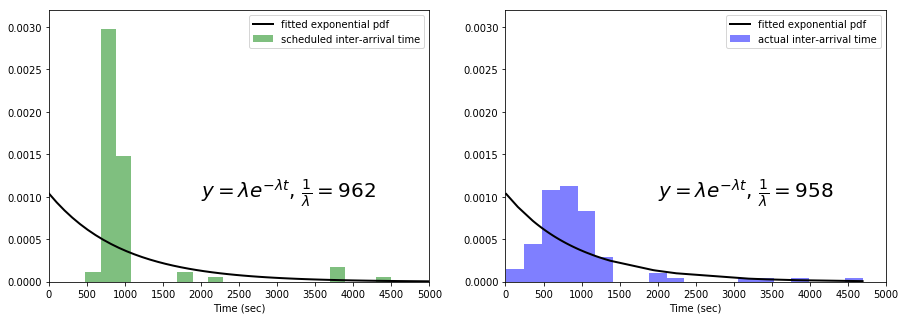

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharey = False)

tmax = 5000 # max value of x axis
exp_x = np.linspace(0, tmax, 50) # equally spaced x values for plotting exponential distributions

# Plotting histogram and fitted exponential distribution for scheduled inter-arrival time

sch_x = df['scheduled_inter_arrival_times'].sort_values()
sch_mean = sch_x.mean()
sch_p = st.expon.fit(sch_x, floc=0)
sch_iat = axs[0].hist(sch_x, bins=20, density=True, facecolor='g', alpha=0.5, \
                      label = "scheduled inter-arrival time")
sch_fit = axs[0].plot(exp_x, st.expon.pdf(exp_x, loc=0, scale=sch_mean), 'k-', lw=2, label='fitted exponential pdf')
axs[0].text(2000, 0.001, r'$y = \lambda e^{-\lambda t}$, ' + r'$\frac{1}{\lambda}=$' + str(round(sch_mean)), fontsize=20)

# Plotting histogram and fitted exponential distribution for actual inter-arrival time

act_x = df['actual_inter_arrival_times'].sort_values()
act_mean = act_x.mean()
act_p = st.expon.fit(act_x)
act_iat = axs[1].hist(act_x, bins=20, density=True, facecolor='b', alpha=0.5, \
                      label = "actual inter-arrival time")
act_fit = axs[1].plot(act_x, st.expon.pdf(act_x, loc=0, scale=act_mean), 'k-', lw=2, label='fitted exponential pdf')
axs[1].text(2000, 0.001, r'$y = \lambda e^{-\lambda t}$, ' + r'$\frac{1}{\lambda}=$' + str(round(act_mean)), fontsize=20)

# View control
for i in range(axs.size):
    axs[i].set_xlabel("Time (sec)")
    axs[i].set_xticks(np.append(tmax, np.arange(0, tmax, 500)))
    axs[i].set_xlim([0, tmax])
    axs[i].set_ylim([0, 0.0032])
    axs[i].legend(loc='upper right')


## Question 2

For this question, assume both scheduled and actual inter-arrival times fit into exponential distributions $X_1 \sim Exp(\lambda_1)$ and $X_2 \sim Exp(\lambda_2)$ respectively. Using the data, estimate $\lambda_1$ and $\lambda_2$. (Hint : $\mathbf{E}{(X)} \cong \dfrac{1}{n} \sum_{i=1}^{n} X_i $ where $X_i$ denotes each data point in the data set). Using the distributions you obtained, answer the following questions.

<ol>
  <li> For each of the queuing system (scheduled and actual bus arrivals), plot the distribution you obtained and the corresponding histogram (from Question 1) on the same graph. </li>
  <li> What type of queuing systems are represented here? Use Kendall's notation to specify them. Are they stable ?</li>
  
  <li> For both queuing systems, calculate, 
        <ol>
        <li> $\overline{N_q}$ : expected number of busses in queue </li>
        <li> $\overline{N}$ : expected number of busses in queuing system </li>
        <li> $\overline{T_q}$ : expected waiting time in queue per busses </li>
        <li> $\overline{T}$ : expected time in queuing system per busses </li>
        </ol>
  </li>
</ol>

<h4>Answers:</h4>
<ol>
<li>
The average (expected) inter-arrival time is found from each data set as $\frac{1}{\lambda_{scheduled}} = 962$ sec/bus and $\frac{1}{\lambda_{actual}} = 958$ sec/bus, and is used as the $\frac{1}{\lambda}$ (headway) parameter in the exponential distributions for each data set. The equation for the fitted exponential distribution of each data set is found by setting $loc = 0$ and $scale = \frac{1}{\lambda}$.

<li>
Since the arrival time follows the Poisson process with $1/\lambda$ = 962 and 958 sec/veh $\rightarrow \lambda \approx 3.75 veh/hr$, the service time is set to 10 minutes meaning $\mu = 6 veh/hr$, and we are assuming only 1 loading zone is available, the queueing system represented here is a M/D/1 system. The system is stable because $\rho = \lambda / \mu < 1$.
   
<li>
For an M/D/1 system:
    $$\rho = \lambda / \mu$$
    $$\overline{N_q} = \frac{\rho^2}{2(1-\rho)}$$
    $$\overline{N} = \overline{N_q} + \rho$$
    $$\overline{T_q} = \frac{\rho}{2\mu(1-\rho)}$$
    $$\overline{T} = \overline{N} * \lambda$$
    <ul>
    <li>
    For the scheduled arrival queueing system:
    $\overline{N_q} = 0.517,\ \overline{N} = 1.14,\ \overline{T_q} = 497,\ \overline{T} = 1097$
    <li>
    For the actual arrival queueing system:
    $\overline{N_q} = 0.526,\ \overline{N} = 1.15,\ \overline{T_q} = 503,\ \overline{T} = 1103$
    </ul>
</ol>

In [10]:
def getNT(l):
    mu = 1/10/60
    rho = l / mu
    Nq = pow(rho, 2)/(2*(1-rho))
    N = Nq + rho
    Tq = rho/(2 * mu*(1 - rho))
    T = (2-rho) / (2 * mu*(1 - rho))
    l = rho * mu
    return Nq, N, Tq, T

## Question 3

From this question onwards, we will be looking into the queueing system corresponding to actual arrival times.

For this question, you will need to determine which distribution best fit your data. In order to do this, you can start with fitting the data set to each of the below mentioned distributions and perform a Kolmogorov-Smirnov test, which assesses the goodness of fit of the distribution with respect to data. You are encouraged to use the [SciPy](https://scipy.org/scipylib/index.html) package in python. 

Fit the actual inter-arrival time data set to each of the below mentioned distributions. For each case, plot the corresponding histogram and obtained distribution on the same graph. Record the p-value for each Kolmogorov-Smirnov test you perform. Clearly state what distribution you choose and justify your choice. 

<ol>
 <li>Exponential distribution</li>
 <li>Birnbaum–Saunders distribution</li>
 <li>Normal distribution </li>
 <li>Folded Cauchy distribution </li>
</ol>


<h4>Answers:</h4>
For each type of distribution, the MLE method was used to find each fitted curve.
<table>
    <tr>
        <th>Test</th>
        <th>p-value</th>
    </tr>
    <tr>
        <td>Exponential distribution</td>
        <td>
        $$2.4*10^{-6}$$
        </td>
    </tr>
    <tr>
        <td>Birnbaum–Saunders distribution</td>
        <td>
        $$2.7*10^{-42}$$
        </td>
    </tr>
    <tr>
        <td>Normal distribution</td>
        <td>
        $$4.7*10^{-5}$$
        </td>
    </tr>
    <tr>
        <td>Folded Cauchy distribution</td>
        <td>
        $$0.80$$
        </td>
    </tr>
</table>
Based on the p-values shown above, Folded Cauchy was chosen for simulating the inter-arrival times because its p-value suggests that the data could come from a Folded Cauchy distribution.

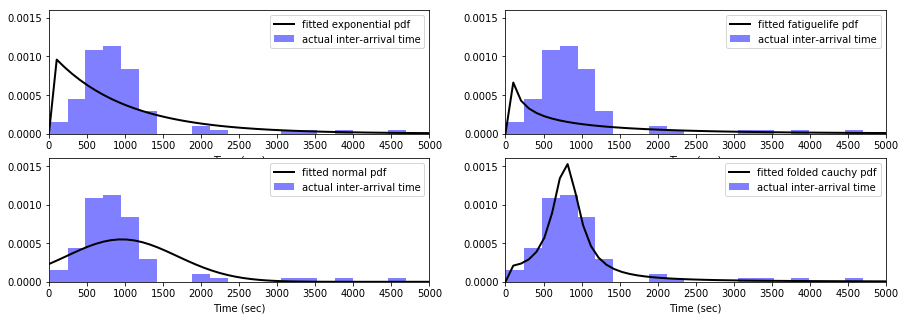

In [112]:
fig, axs = plt.subplots(2, 2, figsize=(15,5), sharey = False)

tmax = 5000 # max value of x axis
exp_x = np.linspace(0, tmax, 50) # equally spaced x values for plotting exponential distributions

# Plotting histogram and fitted exponential distribution for actual inter-arrival time
# Histogram
act_x = df['actual_inter_arrival_times'].sort_values()
act_mean = act_x.mean()
act_p = st.expon.fit(act_x)


# Exponential
e = st.expon.fit(act_x, )
act_fit = axs[0, 0].plot(exp_x, st.expon.pdf(exp_x, loc=e[0], scale=e[1]), 'k-', lw=2, label='fitted exponential pdf')
ep = st.kstest(act_x, 'expon', args=e).pvalue

# Birnbaum-Saunders
f = st.fatiguelife.fit(act_x)
act_fit = axs[0, 1].plot(exp_x, st.fatiguelife.pdf(exp_x, c=f[0], loc=f[1], scale=f[2]), 'k-', lw=2, label='fitted fatiguelife pdf')
fp = st.kstest(act_x, 'fatiguelife', args=f).pvalue

# Normal
n = st.norm.fit(act_x)
act_fit = axs[1, 0].plot(exp_x, st.norm.pdf(exp_x, loc=n[0], scale=n[1]), 'k-', lw=2, label='fitted normal pdf')
normp = st.kstest(act_x, 'norm', args=n).pvalue

# Folded Cauchy
fc = st.foldcauchy.fit(act_x)
act_fit = axs[1, 1].plot(exp_x, st.foldcauchy.pdf(exp_x, c=fc[0], loc=fc[1], scale=fc[2]), 'k-', lw=2, label='fitted folded cauchy pdf')
cp = st.kstest(act_x, 'foldcauchy', args=fc).pvalue

# View control
for i in range(axs.size):
    r, c = int(i % 2), int(i / 2)
    axs[r, c].hist(act_x, bins=20, density=True, facecolor='b', alpha=0.5, \
                      label = "actual inter-arrival time")
    axs[r, c].set_xlabel("Time (sec)")
    axs[r, c].set_xticks(np.append(tmax, np.arange(0, tmax, 500)))
    axs[r, c].set_xlim([0, tmax])
    axs[r, c].set_ylim([0, 0.0016])
    axs[r, c].legend(loc='upper right')


## Question 4

Once the best fit probability distribution is identified for the data set, use stochastic simulations to estimate the following quantities. Note that you can use $\texttt{rvs\((b, loc=0, scale=1, size=1, random\_state=None\))}$ method in SciPy to do random sampling from distributions. <br>

For the queuing system, calculate, 
  <ol>
        <li> $\overline{N_q}$ : expected number of busses in queue </li>
        <li> $\overline{N}$ : expected number of busses in queuing system </li>
        <li> $\overline{T_q}$ : expected waiting time in queue per bus </li>
        <li> $\overline{T}$ : expected time in queuing system per bus </li>
  </ol>

<h4>Answers:</h4>
The code below shows a simulation of bus arrivals where the inter-arrival times are drawn from the Folded Cauchy distribution found above. The simulation was run for 50 times, with 50 bus arrivals in the system each time. Using this simulation, we can find the following values:
<ul>
<li>
    Average number of buses in the system is: 1.29 buses
<li>
    Average time spent in the system is: 685.92 seconds
<li>
    Average number of buses in the queue is: 0.29 buses
<li>
    Average time spent waiting is: 85.92 seconds
</ul>

In [140]:
Ts = []
Nqs = []
Tqs = []
for itr in range(50):
    size = 50
    arr = []
    serv_start = []
    serv = 600
    dep = []
    arr_curve = []
    serv_curve = []
    dep_curve = []
    total_time = 0
    total_wait = 0
    total_serv = 0
    queued_veh = 0
    for i in range(size):
        int_arrival = st.foldcauchy.rvs(c=fc[0], loc=fc[1], scale=fc[2], random_state=None)
        if i == 0:
            curr_arr = 0
            curr_serv_start = 0
            curr_dep = serv
        else:
            curr_arr = arr[-1] + int_arrival
            curr_serv_start = max(curr_arr, dep[-1])
            curr_dep = curr_serv_start + serv
        curr_wait = curr_serv_start - curr_arr
        if curr_wait > 0:
            queued_veh = queued_veh + 1
        total_wait = total_wait + (curr_serv_start - curr_arr)
        total_serv = total_serv + (curr_dep - curr_serv_start)
        total_time = total_time + (curr_dep - curr_arr)
        arr.append(curr_arr)
        arr_curve.append([curr_arr, i])
        arr_curve.append([curr_arr, i+1])

        serv_start.append(curr_serv_start)
        serv_curve.append([curr_serv_start, i])
        serv_curve.append([curr_serv_start, i+1])

        dep.append(curr_dep)
        dep_curve.append([curr_dep, i])
        dep_curve.append([curr_dep, i+1])
    Ts.append(total_time / size)
    Nqs.append(queued_veh)
    Tqs.append(total_wait / size)

In [170]:
from statistics import mean
print(f'Average number of buses in the system is: {round(mean(Nqs) / size + 1, 2)} buses')
print(f'Average time spent in the system is: {round(mean(Ts), 2)} seconds')
print(f'Average number of buses in the queue is: {round(mean(Nqs) / size, 2)} buses')
print(f'Average time spent waiting is: {round(mean(Tqs), 2)} seconds')

Average number of buses in the system is: 1.29 buses
Average time spent in the system is: 685.92 seconds
Average number of buses in the queue is: 0.29 buses
Average time spent waiting is: 85.92 seconds


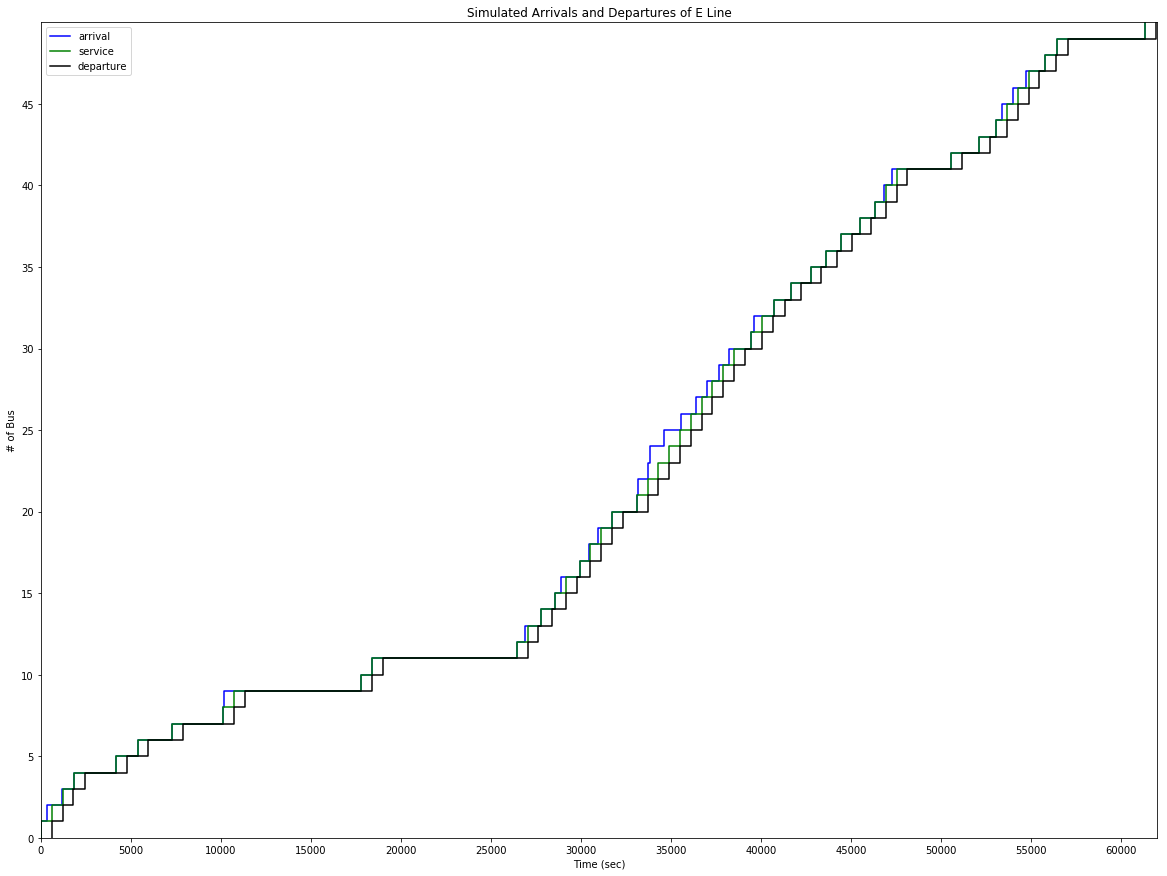

In [142]:
fig, ax = plt.subplots(figsize=(20,15))

a = np.array(arr_curve)
s = np.array(serv_curve)
d = np.array(dep_curve)

sim_a = ax.plot(a[:, 0], a[:, 1], color = 'b', label = "arrival")
sum_s = ax.plot(s[:, 0], s[:, 1], color = 'g', label = "service")
sum_d = ax.plot(d[:, 0], d[:, 1], color = 'k', label = "departure")

# view control
ax.set_xlabel("Time (sec)")
ax.set_ylabel("# of Bus")
ax.set_title('Simulated Arrivals and Departures of E Line')
xmax = int(math.ceil(np.max(dep_curve) / 1000.0)) * 1000
major_ticks = np.arange(0, xmax, 5000)
ax.set_xticks(major_ticks)
ax.set_yticks(np.arange(0, size, 5))
ax.set_xlim([0, xmax])
ax.set_ylim([0, size])

leg = ax.legend(loc='upper left')